# _Can machine learning algorithms predict if a person's wage is enough to cover basic needs? Evidence from socioeconomic data of Chilean individuals_


### Joaquin Perez-Lapillo

Principles of Data Science<br>
MSc in Data Science<br>
City, University of London

***

### Brief description of the project
- Based on national survey data about socioeconomic conditions of Chilean individuals (CASEN Survey 2017) [1].
- The aim is to perform a classification task using different machine learning algorithms to know how well can those methods predict if an individual earns a living wage. 
- A secondary aim is to inform which are the most relevant features in prediction, i.e. what defines if a person earns a living wage.
- Living wage: as defined by international organizations, it represents the wage that meets a person's real cost of living in a certain location [2]. For the case of Chile, in 2018 it was defined in 391,400 Chilean pesos per month (roughly £700 at PPP) [3].




***

[1] http://observatorio.ministeriodesarrollosocial.gob.cl/casen-multidimensional/casen/basedatos.php<br>
[2] https://www.livingwage.org.uk/what-real-living-wage<br>
[3] https://wageindicator.org/salary/living-wage/chile-living-wages-2018-country-overview


### Step 1: Import libraries and data

In [148]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For ignoring warning messages
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('ggplot')
#%matplotlib inline

# Importing data
df = pd.read_csv('casen2017.csv', engine='python')
print(df.shape)

(216439, 804)


The entire dataset includes 216,439 observations and 804 columns. Most of the columns are questions that help build aggregates such as 'total income' or 'wage'. For that reason, we are going to select just a few of those for the study. 

The features that will be selected have relation to previous work in the areas of income prediction and determinants of the income of workers. The list includes age, gender, years of education and experience, hours worked and ethnic group. In addition, relevant characteristics of the job will be added, such as the type of contract, sector, industry, and position and some less standard demographic variables like affiliation to social security, bank account possession and self-reported health condition.

### Step 2: Selecting variables for study

In [149]:
# Filtering variables
cols = ['ecivil','region','zona','sexo','edad','esc','activ','r3','o10','o12','o15',
        'o13','o28','oficio1','rama1','y27b','s13','y0101c']

df_filter = df.filter(cols)
print(df_filter.shape)

# Rename variables using Book of Codes of the survey
df_filter = df_filter.rename(columns={'ecivil': 'maritalst', 'y0101c': 'income', 'zona': 'zone', 'sexo': 'sex',
                                      'edad': 'age','esc':'education','r3': 'ethni','o12':'jobtype','o13':'year',
                                      'o15': 'sector','rama1':'industry','oficio1': 'position', 'o28':'socsec',
                                      'y27b':'bankacc','s13':'health', 'o10':'hours'})

(216439, 18)


We will work with 16 features and 1 target variable ('income'), that will be transformed into a binary target later in the project. The variables were selected from the Book of Codes of the 2017 CASEN Survey available on the web [4]. <br> 
An important number of the independant variables are categorical, so we first need to declare them as it.
***
[4] http://observatorio.ministeriodesarrollosocial.gob.cl/casen-multidimensional/casen/docs/Libro_de_Codigos_Casen_2017.pdf

In [150]:
# Declaring list of categorical variables into 'type: categorical'
cat_cols = ['maritalst','region','zone','sex','ethni','jobtype','sector','socsec','position','industry','bankacc','health']
df_filter[cat_cols] = df_filter[cat_cols].astype('category')

### Step 3: Initial processing

**3.1.** Keeping active workers: The dataset includes some individuals without income and some that are not currently in the labor market. Because of the scope of the study, we need to drop them to keep only active workers.

In [151]:
# Deleting observations without income and not currently in the labor market
df_imp = df_filter[pd.notnull(df_filter['income'])]
df_imp = df_imp[df_imp['activ']==1]
del df_imp['activ']

print(df_imp.shape)
df_imp.head()

(67409, 17)


,maritalst,region,zone,sex,age,education,ethni,hours,jobtype,sector,year,socsec,position,industry,bankacc,health,income
1,8,1,1,2,21,7.0,10,59.0,1.0,7.0,2015.0,2.0,9.0,16.0,2.0,5,200000.0
2,2,1,1,1,24,12.0,10,8.0,1.0,5.0,2016.0,1.0,5.0,8.0,9.0,4,270000.0
3,2,1,1,1,28,12.0,10,8.0,1.0,5.0,2017.0,2.0,5.0,8.0,9.0,4,300000.0
4,1,1,1,1,26,15.0,10,8.0,1.0,5.0,2016.0,1.0,9.0,16.0,9.0,9,320000.0
9,5,1,1,2,59,12.0,10,70.0,1.0,5.0,2012.0,1.0,8.0,7.0,2.0,1,270000.0


The resulting dataset has 67,409 observations.

**3.2** Obtaining 'years of experience': the dataset includes a variable 'year' which is the year the individual started working on his current occupation.

In [152]:
# 'year' inidcates the year the individual started working. Printing some descriptive statistics
print('Summary statistics: Year that the individual started working')
print(df_imp.year.describe())

# We see that there are some observations with year='9999' that we have to replace
# We decide to use the median (2013) because the mean is being affected by outliers
df_imp.year.replace([9999], [df_imp['year'].median()], inplace=True)

# Creating a new variable 'exp' = years of experience
df_imp['experience'] = 2018 - df_imp['year']

# Print to check outcome
print('-'*40)
print('Summary statistics: Years of experience')
print(df_imp.experience.describe())

# Deleting the original variable
del df_imp['year']

# To check for outliers: comparing age and experience
df_imp['check'] = df_imp['age'] - df_imp['experience']
print('-'*40)
print('Summary statistics: Difference between age and experience (in years)')
print(df_imp.check.describe())

# We see that there are some outliers that need to be excluded
# Deleting individuals that started working before they were 15 years old
df_imp = df_imp[(df_imp.check >= 15)]
del df_imp['check']

Summary statistics: Year that the individual started working
count    67409.000000
mean      2049.695367
std        560.183134
min       1930.000000
25%       2008.000000
50%       2014.000000
75%       2017.000000
max       9999.000000
Name: year, dtype: float64
----------------------------------------
Summary statistics: Years of experience
count    67409.000000
mean         7.750478
std          9.246943
min          0.000000
25%          1.000000
50%          4.000000
75%         10.000000
max         88.000000
Name: experience, dtype: float64
----------------------------------------
Summary statistics: Difference between age and experience (in years)
count    67409.000000
mean        33.611283
std         12.458784
min        -42.000000
25%         24.000000
50%         31.000000
75%         42.000000
max         97.000000
Name: check, dtype: float64


**3.3** Creating a categorical target variable using the Chilean living wage as a threshold

In [153]:
# Creating a categorical target variable:
# income_cat=0 --> less than the living wage ; income_cat=1 --> more than the living wage
df_imp['income_cat'] = 0
living_wage = 391400
df_imp['income_cat'] = np.where(df_imp['income'] >= living_wage,1,0)

### Step 4: Dealing with missing values and outliers

In [154]:
# Missing values report
print(df_imp.isnull().sum())

maritalst       0
region          0
zone            0
sex             0
age             0
education     409
ethni           0
hours          57
jobtype         0
sector          0
socsec          0
position        0
industry        0
bankacc         0
health          0
income          0
experience      0
income_cat      0
dtype: int64


We see that only 'education' and 'hours' have missing values.

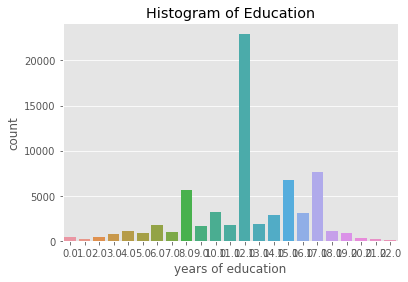

In [155]:
# Plotting education to explore alternatives to addressing missing values:
sns.countplot(x='education',data=df_imp)
plt.title('Histogram of Education')
plt.xlabel('years of education')
plt.show()

In [156]:
# Because education has a clear mode, the choise will be to fill missings with '12'. 
df_imp['education'] = df_imp['education'].fillna(12)

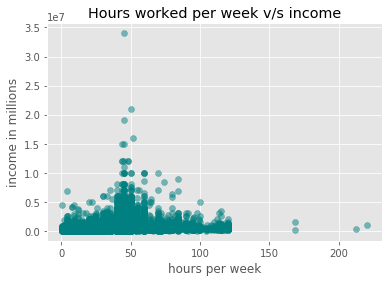

--------------------------------------------------
Summary statistics: hours worked per week
count    66533.000000
mean        43.923527
std         12.326263
min          1.000000
25%         44.000000
50%         45.000000
75%         45.000000
max        220.000000
Name: hours, dtype: float64


In [157]:
# Plotting weekly hours worked to explore alternatives to addressing missing values:
plt.scatter(df_imp['hours'], df_imp['income'], color='teal', alpha=0.5)
plt.title('Hours worked per week v/s income')
plt.xlabel('hours per week')
plt.ylabel('income in millions')
plt.show()
print('-'*50)
print('Summary statistics: hours worked per week')
print(df_imp.hours.describe())

We see that most people work 45 hours per week, and that there are some outliers to deal with. To do that, we define a limit of 72 hours worked as a valid number (12 hours per day, monday to saturday).

In [158]:
# Replacing missing values and outliers of 'hours' with the median (45)
df_imp['hours'] = df_imp['hours'].fillna(45)
df_imp['hours'] = np.where(df_imp['hours'] >= 72,45,df_imp['hours'])

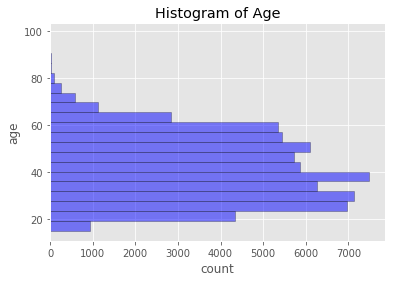

In [159]:
# Plotting age to check for outliers:
plt.hist('age',data=df_imp, bins=20,color='b',orientation = 'horizontal',alpha=0.5,ec='black')
plt.title('Histogram of Age')
plt.xlabel('count')
plt.ylabel('age')
plt.show()

There is people over 70 years old classified as active workers, which is unlikely to happen. We decide to drop those observations to keep only relevant workers.

In [160]:
# As we are considering only active people, observations with age > 70 will be deleted
df_imp = df_imp[df_imp['age'] <= 70]
df_imp.shape

(65788, 18)

The final dataset includes 65,788 individuals, without outliers or missings and keeping only observations that are relevant to the problem of the study. 

### Step 5: Performing Visual Exploratory Data Analysis

**5.1** Describing the income distribution of Chilean individuals

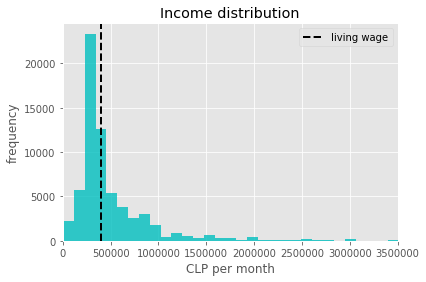

In [161]:
# Income distribution
plt.hist(df_imp.income, bins=300, alpha=0.8, color='c')
plt.title('Income distribution')
plt.ylabel('frequency')
plt.xlabel('CLP per month')
plt.xlim(0,3500000)
plt.axvline(living_wage, color='k', linestyle='dashed', linewidth=2, label='living wage')
plt.legend()
plt.show()

We see a clear right skewed distribution (as in most countries). The black dashed line shows the living wage of $391k per month defined.

In [162]:
# To see how are the two categories represented in the dataset (minority/mayority class ratio)
count = df_imp.income_cat.value_counts()
print('Minority class (income_cat == 1):', round(count[1]/(count[0]+count[1])*100,1),'%')

Minority class (income_cat == 1): 43.8 %


Individuals earning a living wage represent 43.8 % of total. Hence, we say that the dataset is relatively balanced.

**5.2** Exploring correlation between income and continuous variables and their distributions over the two target groups

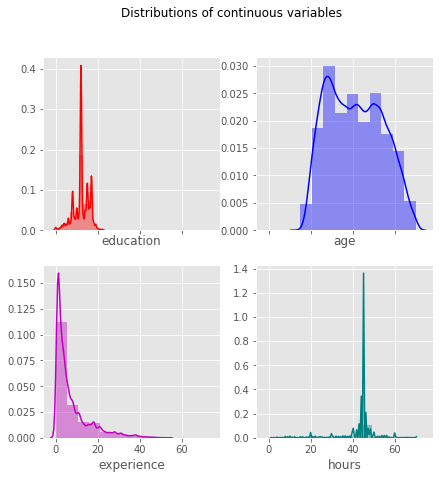

In [163]:
# Plotting histograms of continuous variables as an initial approach: education, age, hours and experience
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
plt.suptitle('Distributions of continuous variables')
sns.distplot(df_imp["education"],color='r',ax=axes[0, 0],bins=10)
sns.distplot(df_imp["age"],color='b', ax=axes[0, 1],bins=10)
sns.distplot(df_imp["experience"],color='m',ax=axes[1, 0],bins=10)
sns.distplot(df_imp["hours"],color='teal',ax=axes[1, 1],bins=10)
plt.show()

- We see that 'education' has 4 clear peaks, presumably on 8, 12, 15 and 17 years (elementary school, high school, college, and university degrees).
- As seen before, 'age' has a right-skewed distribution with a peak around 30 years.
- 'experience' shows a clear right-skewed distribution (most workers have low experience).
- 'hours' is centered at 45 hours a week which is the standard in Chile.


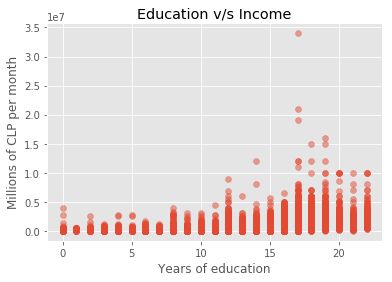

Pearsons:  0.4 ; Spearmans: 0.51 .


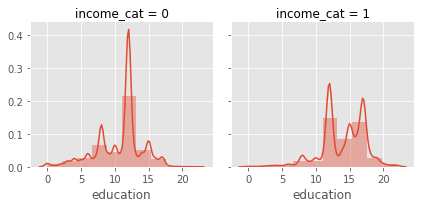

In [164]:
# Plotting education versus income
plt.scatter(df_imp.education, df_imp.income,alpha=0.5)
plt.title('Education v/s Income')
plt.xlabel('Years of education')
plt.ylabel('Millions of CLP per month')
plt.show()

# Correlation coefficients
pearson = stats.pearsonr(df_imp.education, df_imp.income)
spearman = stats.spearmanr(df_imp.education, df_imp.income)
print('Pearsons: ',round(pearson[0],2),'; Spearmans:',round(spearman[0],2),'.')

# Education versus income category
g = sns.FacetGrid(df_imp, col='income_cat')
g = g.map(sns.distplot, 'education', bins=10)
plt.show()

Education v/s Income:
- Correlation coefficients (Pearsons=0.40; Spearmans=0.51) tell us that there is a relatively strong positive correlation between education and income. The gap between them shows that the relationship is not linear but most probably quadratic.
- For the first group (income_cat=0), there are clear peaks at 8 and 12 years of education (elementary and high school), whereas for the second one (income_cat=1) the peaks are at 12, 15 and 17 years (high school, college, and university). Thus, we conclude that the probability distributions of both groups are different and that 'education' shows great potential as a predictor the two groups.

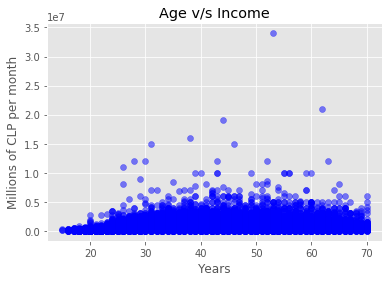

Pearsons:  0.06 ; Spearmans: 0.05 .


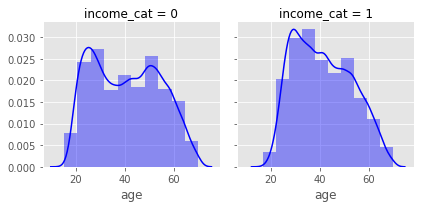

In [165]:
# Plotting age versus income
plt.scatter(df_imp.age, df_imp.income,alpha=0.5, color='b')
plt.title('Age v/s Income')
plt.xlabel('Years')
plt.ylabel('Millions of CLP per month')
plt.show()

# Correlation coefficients
pearson = stats.pearsonr(df_imp.age, df_imp.income)
spearman = stats.spearmanr(df_imp.age, df_imp.income)
print('Pearsons: ',round(pearson[0],2),'; Spearmans:',round(spearman[0],2),'.')

# Age versus income categories
g = sns.FacetGrid(df_imp, col='income_cat')
g = g.map(sns.distplot, 'age',color='blue', bins=10)
plt.show()

Age v/s Income:
- Since correlation coefficients (Pearsons=0.06; Spearmans=0.05) are close to zero, we conclude that there is no correlation between age and income. 
- However, we see different distributions since the first group (income_cat=0) shows a bimodal distribution with peaks at 30 and 50 years, meanwhile the second one (income_cat=1) has only one peak at around 35. This could be relevant for ML algorithms to separate both groups of individuals later on the project.

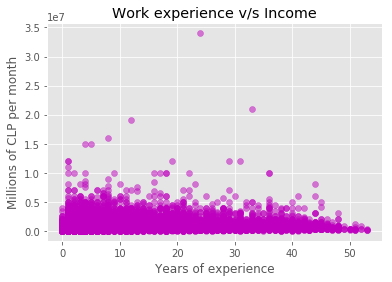

Pearsons:  0.17 ; Spearmans: 0.26 .


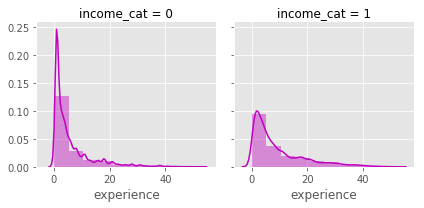

In [166]:
# Plotting work experience versus income
plt.scatter(df_imp.experience, df_imp.income,alpha=0.5, color='m')
plt.title('Work experience v/s Income')
plt.xlabel('Years of experience')
plt.ylabel('Millions of CLP per month')
plt.show()

# Correlation coefficients
pearson = stats.pearsonr(df_imp.experience, df_imp.income)
spearman = stats.spearmanr(df_imp.experience, df_imp.income)
print('Pearsons: ',round(pearson[0],2),'; Spearmans:',round(spearman[0],2),'.')

# Experience versus income categories
g = sns.FacetGrid(df_imp, col='income_cat')
g = g.map(sns.distplot, 'experience',color='m',bins=10)
plt.show()

Experience v/s Income:
- Since correlation coefficients (Pearsons=0.17; Spearmans=0.26) are relatively low, we conclude that there is a weak positive correlation between work experience and income.
- Both groups show right-skewed distributions, but income_cat=0 show more kurtosis. This means that there are more chances to not earn a living wage having little work experience.
- Since there seems to be not great differences between classes, the predicting potential of this variable should be limited. 

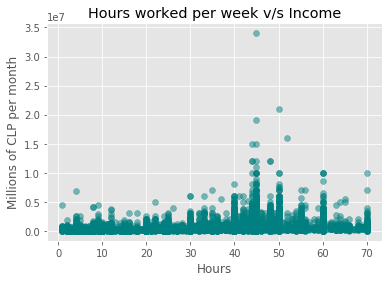

Pearsons:  0.13 ; Spearmans: 0.16 .


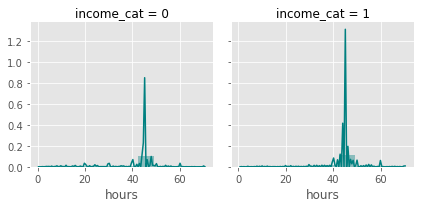

In [167]:
# Plotting Hours worked versus income
plt.scatter(df_imp.hours, df_imp.income,alpha=0.5, color='teal')
plt.title('Hours worked per week v/s Income')
plt.xlabel('Hours')
plt.ylabel('Millions of CLP per month')
plt.show()

# Correlation coefficients
pearson = stats.pearsonr(df_imp.hours, df_imp.income)
spearman = stats.spearmanr(df_imp.hours, df_imp.income)
print('Pearsons: ',round(pearson[0],2),'; Spearmans:',round(spearman[0],2),'.')

# Hours worked versus income categories
g = sns.FacetGrid(df_imp, col='income_cat')
g = g.map(sns.distplot, 'hours',color='teal',bins=10)
plt.show()

Hours worked v/s Income:
- Since correlation coefficients (Pearsons=0.13; Spearmans=0.16) are relatively low, we conclude that there is a weak positive correlation between hours worked per week and income.
- Both group's distributions are centered in 45 hours, but income_cat=1 has higher kurtosis. This means that it is more likely to overcome the threshold when individuals work 45 hours per week. However, this feature shows the less potential for prediction.

**5.3** Correlation matrix: explore relationships between continuous features

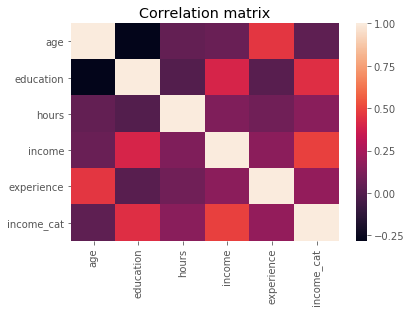

In [168]:
# Correlation matrix
sns.heatmap(df_imp.corr())
plt.title('Correlation matrix')
plt.show()

Some observations:
- There is a negative correlation between age and education, meaning that young workers are more educated than older workers. This makes sense considering that access to universities in Chile was significantly expanded after a reform in the 2000s.
- There is a strong positive correlation between age and experience.
- No significant correlation between hours worked and other continuous variables.

**5.4** Performing EDA over categorical variables

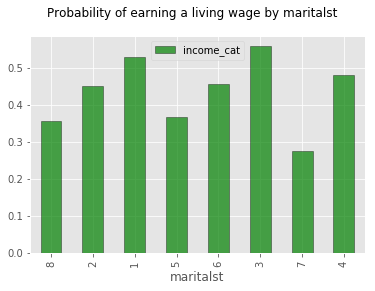

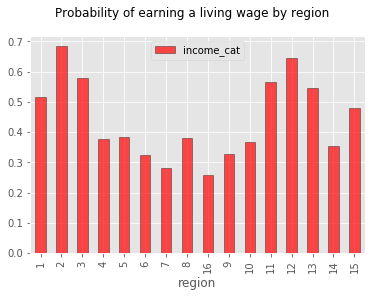

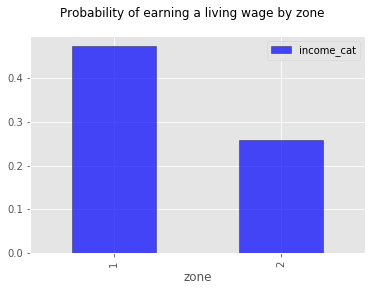

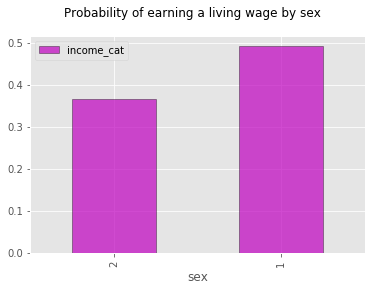

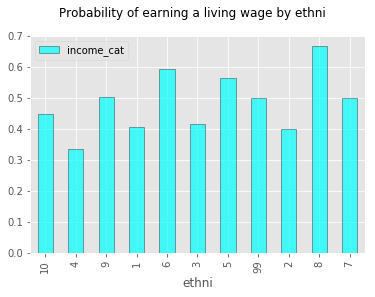

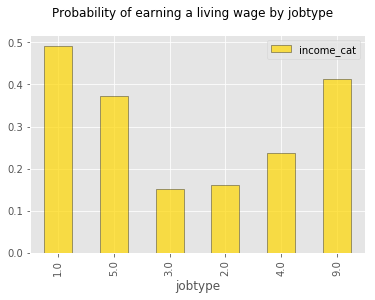

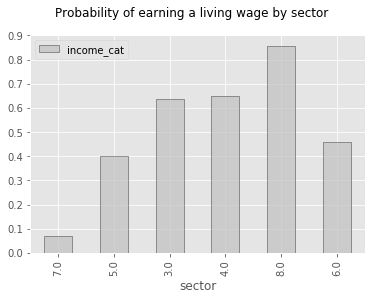

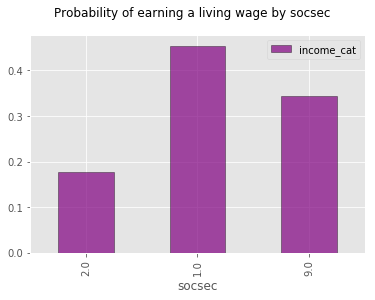

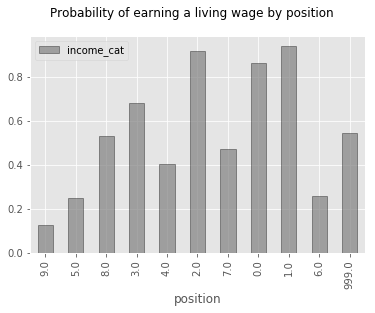

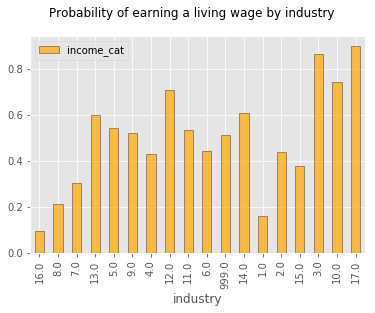

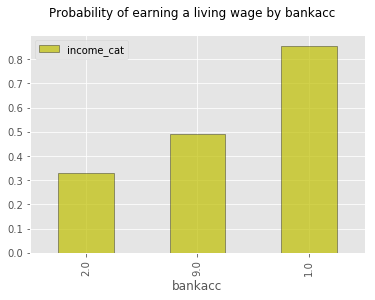

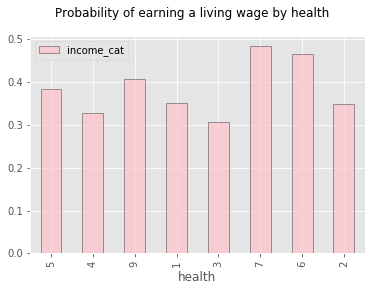

In [169]:
# Plotting categorical variables
# defining colors list
colors = ['g','r','b','m','cyan','gold','silver','purple','grey','orange','y','pink']

# defining a function to iterate over
def plot_vars(column, color):
    var_pivot = df_imp.pivot_table(index=column,values='income_cat')
    var_pivot.plot.bar(color=color,alpha=0.7,ec='black')
    plt.suptitle('Probability of earning a living wage by {}'.format(column))
    plt.show()
    
# calling the function on all categorical variables
for i in range(12):
    plot_vars(cat_cols[i],colors[i])

Observations on categorical variables*: <br>
- Characteristics of individuals that are **more likely** to earn a living wage:
    - Men (sex=1)
    - Married (maritalst=1)
    - Living in extreme regions (region={1,2,3,11,12}) and the capital (13)
    - Having a permanent-fulltime contract (jobtype=1)
    - Working for the government (sector={3,4}) or the armed forces (8)
    - Having a social security savings account (socsec=1)
    - Professionals (position=2), military (0) and politicians (1)
    - Working in mining (industry=3), financial companies (10) and government (12, 17)
    - Having a current bank account (bankacc=1)
    - People that declare being in good health condition (health={6,7})


- Characteristics of individuals that are **less likely** to earn a living wage:
    - Women (sex=2)
    - Single (maritalst=8)
    - Living in the center regions of the country (region={4,5,6,7,8,9,10})
    - Having a part-time contract (jobtype={2,5})
    - Being self-employed(sector=2)
    - Not having a social security savings account (socsec={2,9})
    - Salespersons (position=5), operators (7), farmers (6) and having no qualifications (9)
    - Working in farming (industry=1), restaurants&accommodation (8) and retail companies (7)
    - Not having a bank account (bankacc={2,9})
    - People that declare being in a poor health condition (health=~{6,7})

*Based on the book of codes of CASEN 2017 survey [4].
 

### Step 6: Data preparation for ML algorithms

**6.1** Deleting original income column since our task will be classification

In [170]:
# deleting original income column
del df_imp['income']

**6.2** Create a dummy dataset: because one of the models that will be used to perform classification is Logistic Regression, we need to create an alternative dataset with only numerical/binary variables. This means that we need to create dummy variables for each categorical variable state.

In [171]:
# Transforming categorical variables into dummies, then deleting original variables
dummies = pd.get_dummies(df_imp[cat_cols], prefix=cat_cols)
df_imp_dum = pd.concat([df_imp,dummies], axis=1)
df_imp_dum = df_imp_dum.drop(cat_cols, 1)
df_imp_dum.head()

,age,education,hours,experience,income_cat,maritalst_1,maritalst_2,maritalst_3,maritalst_4,maritalst_5,...,bankacc_2.0,bankacc_9.0,health_1,health_2,health_3,health_4,health_5,health_6,health_7,health_9
1,21,7.0,59.0,3.0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,24,12.0,8.0,2.0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,28,12.0,8.0,1.0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,26,15.0,8.0,2.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
9,59,12.0,70.0,6.0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0


**6.3** Scaling and performing PCA: the resulting dataset with dummy variables has 102 columns. We will continue by trying PCA as an alternative to reduce dimensionality. But before that, we need to transform all variables to the same scale.

In [172]:
# Scaling variables: using [0,1] interval to match dummy variables
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df_imp_dum_scal = min_max_scaler.fit_transform(df_imp_dum)
df_imp_dum_scal = pd.DataFrame(df_imp_dum_scal)
# deleting target variable
del df_imp_dum_scal[4]

In [173]:
# Performing PCA to reduce dimensionality
from sklearn.decomposition import PCA
# model with 2 components
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df_imp_dum_scal)
var_exp = pca.explained_variance_ratio_
print(var_exp)
total = 0
for i in var_exp:
    total = total + i
print('-'*70)
print('Total variance explained by PCA:', round(total,2)*100,'%')

[0.09271657 0.07790121 0.06020337 0.05065084 0.04747076 0.03859288
 0.03814586 0.0359247  0.03375149 0.03027109]
----------------------------------------------------------------------
Total variance explained by PCA: 51.0 %


We see that performing PCA to reduce dimensionality is not efficient since with 10 components we just explain 51% of the variance. Since the number of principal components needed to explain a significant amount of the variance would be too high, we decide to run the algorithm with the original 102 variables.

**6.4** Train test split over the two alternative datasets (original and dummy)

In [174]:
# Train test split over original dataset
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_imp, test_size=0.3, random_state=1)
# Defining predictors
train_predictors = train.columns[:16]
test_predictors = test.columns[:16]

In [175]:
# Train test split over dummy dataset
train_dum, test_dum = train_test_split(df_imp_dum, test_size=0.3, random_state=1)
# Defining predictors
train_dum_predictors = train_dum[list(train_dum.columns[0:4]) + list(train_dum.columns[5:])]
test_dum_predictors = test_dum[list(test_dum.columns[0:4]) + list(test_dum.columns[5:])]

### Step 7: Performing classification using ML algorithms

**7.1** We will perform supervised learning using four algorithms: Naive Bayes (NB), Decision trees (DT), Random forest (RF) and Logistic regression (LR) in a binary classification context (evaluation criteria: to maximize accuracy in classification of both classes).

**7.1.1** Naive Bayes

In [176]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
nb = GaussianNB()
nb_model = nb.fit(train[train_predictors], train['income_cat'])
nb_predictions = nb_model.predict(test[test_predictors])
nb_accuracy = accuracy_score(test['income_cat'], nb_predictions)
print('NB Accuracy:',round(nb_accuracy*100,1),'%')

NB Accuracy: 73.2 %


**7.1.2** Decision Trees

In [177]:
# Decision trees
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt_model = dt.fit(train[train_predictors], train['income_cat'])
dt_predictions = dt_model.predict(test[test_predictors])
dt_accuracy = accuracy_score(test['income_cat'], dt_predictions)
print('DT Accuracy:',round(dt_accuracy*100,1),'%')

DT Accuracy: 72.8 %


**7.1.3** Random forest

Before running Random forest, we will perform a 5-fold cross-validated grid search due to the importance of hyperparameter tuning for this algorithm. <br>
This process will be conducted by iterating over number of trees, features per node, max depth of the trees and measure criterion.

In [187]:
# Random forest grid search
# Calling the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=1)
# Selecting parameters to iterate over
param_grid = {'n_estimators': [5, 10, 100, 300],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [5, 10, 15, 20],
              'criterion' : ['gini', 'entropy']}
# Running 5-fold cross-validation grid search 
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rf.fit(train[train_predictors], train['income_cat'])
print('Best Hyperparameters for RF:',CV_rf.best_params_)

Best Hyperparameters for RF: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 300}


In [249]:
# Random forest
# Using best hyperparameters to build a final model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, max_depth=15, criterion='entropy', random_state=1)
rf_model = rf.fit(train[train_predictors], train['income_cat'])
rf_predictions = rf_model.predict(test[test_predictors])
rf_accuracy = accuracy_score(test['income_cat'], rf_predictions)
print('RF Accuracy:',round(rf_accuracy*100,1),'%')

RF Accuracy: 81.4 %


**7.1.4** Logistic regression

In [180]:
# Logistic regression (on dummy dataset)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(train_dum_predictors, train_dum['income_cat'])
lr_predictions = lr_model.predict(test_dum_predictors)
lr_accuracy = accuracy_score(test_dum['income_cat'], lr_predictions)
print('LR Accuracy:',round(lr_accuracy*100,1),'%')

LR Accuracy: 81.1 %


**7.2** Visualization of results

**7.2.1** Overall accuracy score

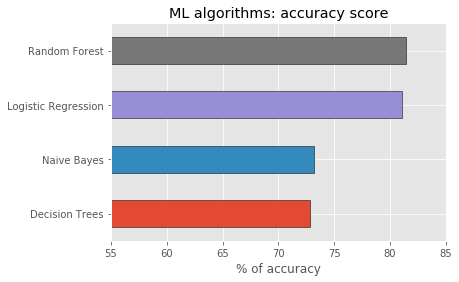

In [189]:
# Visualization of accuracy scores per model
models = ['Naive Bayes','Decision Trees','Random Forest','Logistic Regression']
accuracy = np.array([nb_accuracy, dt_accuracy, rf_accuracy, lr_accuracy])
accuracy = accuracy*100
accuracy_serie = pd.Series(accuracy, index=models).sort_values()
accuracy_serie.plot.barh(ec='black')
plt.title('ML algorithms: accuracy score')
plt.xlim(55,85)
plt.xlabel('% of accuracy')
plt.show()

- Accuracy scores obtained for RF and LR are significantly greater than DT and NB.
- Both RF and LR classify test set observations correctly more than 4/5 of the times.

**7.2.2** ROC Curves

In [190]:
# Defining function for ROC curve plotting
from sklearn import metrics
def plot_model(name, model, color):
    if name == 'LR':
        probs = model.predict_proba(test_dum_predictors)
        probs = probs[:, 1] 
        auc = metrics.roc_auc_score(test_dum['income_cat'], probs)
        fpr, tpr, thresholds = metrics.roc_curve(test_dum['income_cat'], probs)
        plt.plot(fpr, tpr, color=color, label=name+' auc: %0.3f' %auc)
        plt.legend(loc="lower right")
    else:
        probs = model.predict_proba(test[test_predictors])
        probs = probs[:, 1]
        auc = metrics.roc_auc_score(test['income_cat'], probs)
        fpr, tpr, thresholds = metrics.roc_curve(test['income_cat'], probs)
        plt.plot(fpr, tpr, color=color, label=name+' auc: %0.3f' %auc, lw=3)
        plt.legend(loc="lower right")

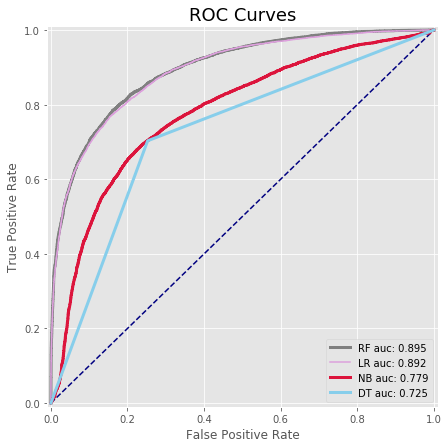

In [191]:
# Plotting ROC curves
plt.figure(figsize=(7,7))
# plot diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
# general graph definitions
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontsize=18)
# calling function on each model
plot_model('RF', rf_model, 'grey')
plot_model('LR', lr_model, 'plum')
plot_model('NB', nb_model, 'crimson')
plot_model('DT', dt_model, 'skyblue')
plt.show()

- According to a scale frequently used when comparing performance of algorithms [5], AUC scores of RF and LR can be classified as **"good"** results (almost "excelent") while NB and DT could only be classified as **"fair"**. 
- We confirm that the performances of RF and LR are significantly better than NB and DT
***
[5] http://gim.unmc.edu/dxtests/roc3.htm

### Step 8: Feature importance analysis

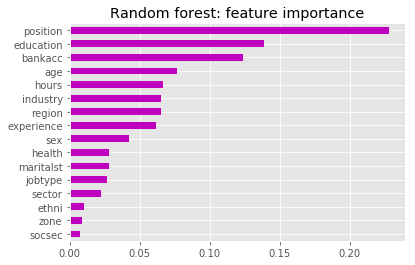

In [192]:
# RF feature importance
rf_importance = rf.feature_importances_
rf_importance = pd.Series(rf_importance, index=train.columns[:16]).sort_values()
rf_importance.plot.barh(color='m')
plt.title('Random forest: feature importance')
plt.show()

- **Job position** and **years of education** were selected as the most important features in prediction by RF. In the case of job position, the decision seems logic due to the nature of the variable (higher positions are associated to the higher salaries) and for education, the graph confirms the strong relationship to income described when correlation coefficients were calculated.
- Having a **bank account** seems to be very relevant in predicting living wage, which could be saying that banks in Chile are unwilling to incorporate people with low income as their clients.
- Although they did not seem highly important when EDA was performed, **age** and **hours** were selected as part of the top 5 of most important features.
- Living in a certain **region** seems also relevant in prediction. This shows the need for having different living wages for each group of regions (extreme, centre, and capital).
- **Experience** is much less relevant than education for defining if an indivudual earns a living wage. 

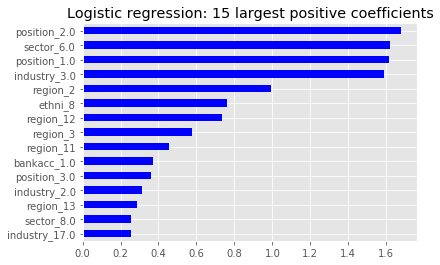

In [247]:
# LR feature importance (possitive coefficients)
lr_coefficients = lr_model.coef_
lr_coefficients = pd.Series(lr_coefficients[0], index=train_dum_predictors.columns)
lr_coefficients_largest = lr_coefficients.nlargest(n=15).sort_values()
lr_coefficients_largest.plot.barh(color='blue')
plt.title('Logistic regression: 15 largest positive coefficients')
plt.show()

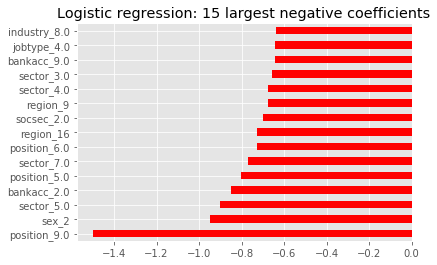

In [186]:
# LR feature importance (negative coefficients)
lr_coefficients = lr_model.coef_
lr_coefficients = pd.Series(lr_coefficients[0], index=train_dum_predictors.columns)
lr_coefficients_largest = lr_coefficients.nsmallest(n=15, keep='first').sort_values()
lr_coefficients_largest.plot.barh(color='r')
plt.title('Logistic regression: 15 largest negative coefficients')
plt.show()

The two graphs obtained for most relevant positive and negative LR coefficients will serve as a complement to the findings obtained with RF feature importance. With this analysis, we can see now which of the states of the categorical variables are more relevant for the classification of individuals into the two groups:
- **Job position:** being a professional in a company ('position'=2) or a position in government ('position'=1) makes an individual highly likely to earn a living wage, as opposed to having a job that requires no qualifications ('position'=9), working as a salesperson ('position'=5) or a farmer ('position'=6).
- **Industry:** individuals working in the mining industry ('industry'=3) are the ones that have better chances to earn a living wage. On the other hand, people working in restaurants and accommodation ('industry'=8) have fewer chances.
- **Region:** people living in extreme regions ('region'=2,3,11,12) and the capital ('region'=13) have better odds to overcome the threshold as opposed to people living in regions 16 and 9.
- **Sex:** females ('sex'=2) are less likely to earn a living wage.

***
### Final remarks:
- The project showed that **Random forest** and **Logistic regression** achieve high performance when classifying individuals into the two target groups, obtaining accuracy scores of 81.4% and 81.1% respectively. In consequence, we say that these ML algorithms are well suited to predict if an individual earns a living wage in Chile given a set of socioeconomic variables.
- The most relevant features that were found in predicting the target were **job position** and **years of education**. Other relevant features that were found were bank account holding, age, hours worked per week, and region.
- More specifically, having job positions such as professionals and governmental agents, living in extreme regions and the capital and working on mining industry were found the categories most likely to earn a living wage.
- On the other hand, having a job that requires no qualifications, working as a salesperson or a farmer, living in regions like Nuble and Araucania and working in restaurants and accommodation are the categories less likely to earn a living wage.
- The study showed the need for having different living wages for macrozones of the country (extreme regions, centre and capital) due to their relevance in the prediction.
***